In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in  Google Drive
file_path = '/content/drive/MyDrive/amazon/amazon.csv'

# Read the dataset into a DataFrame
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(df.columns)

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')


In [5]:
# checking null values
nullvalue = df.isna().sum()
# Remove rows
df.dropna(subset=['rating_count'], inplace=True)
# Remove column
df.drop('product_link',axis=1,inplace=True)
# Duplicate check
df.duplicated().sum()
print("No change in dataset as there is no duplicated rows.")
print("Dataset remains as ", df.shape[0], " rows and ", df.shape[1], " columns")


No change in dataset as there is no duplicated rows.
Dataset remains as  1463  rows and  15  columns


In [6]:
# Clean data header names
namechange={"product_id":"Product ID", "product_name":"Product Name", "category":"Category", "discounted_price":"Discounted Price", "actual_price":"Actual Price", "discount_percentage":"Discount Percentage", "rating":"Rating", "rating_count":"Rating Count", "about_product":"About Product", "user_id":"User ID", "user_name":"User Name", "review_id":"Review ID", "review_title":"Review Title", "review_content":"Review Content", "img_link":"IMG Link", "product_link":"Product Link"}
df = df.rename(columns=namechange)


In [7]:
# Replace symbols for relevant columns
# Convert relevant columns to string type if they contain numeric or other non-string values
df['Discounted Price'] = df['Discounted Price'].astype(str)
df['Actual Price'] = df['Actual Price'].astype(str)
df['Discount Percentage'] = df['Discount Percentage'].astype(str)
df['Rating Count'] = df['Rating Count'].astype(str)

# Replace symbols for relevant columns
df['Discounted Price'] = df['Discounted Price'].str.replace("₹",'').str.replace(",",'')
df['Actual Price'] = df['Actual Price'].str.replace("₹",'').str.replace(",",'')
df['Discount Percentage'] = df['Discount Percentage'].str.replace("%",'')
df['Rating Count'] = df['Rating Count'].str.replace(",",'')

# After converting the columns to string type and replacing symbols
df['Product ID'].value_counts()

df['Product Name'].unique()



array(['Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini (3 FT Pack of 1, Grey)',
       'Ambrane Unbreakable 60W / 3A Fast Charging 1.5m Braided Type C Cable for Smartphones, Tablets, Laptops & other Type C devices, PD Technology, 480Mbps Data Sync, Quick Charge 3.0 (RCT15A, Black)',
       'Sounce Fast Phone Charging Cable & Data Sync USB Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini & iOS Devices',
       ...,
       'Bajaj Majesty RX10 2000 Watts Heat Convector Room Heater (White, ISI Approved)',
       'Havells Ventil Air DSP 230mm Exhaust Fan (Pista Green)',
       'Borosil Jumbo 1000-Watt Grill Sandwich Maker (Black)'],
      dtype=object)

In [8]:
# Resolve error for the conversion of Rating
unique_ratings = df['Rating'].unique()
print(unique_ratings)
df = df.loc[df['Rating'] != '|'] # remove column from dataset


['4.2' '4.0' '3.9' '4.1' '4.3' '4.4' '4.5' '3.7' '3.3' '3.6' '3.4' '3.8'
 '3.5' '4.6' '3.2' '5.0' '4.7' '3.0' '2.8' '4' '3.1' '4.8' '2.3' '|' '2'
 '3' '2.6' '2.9']


In [9]:
# Convert data type to float
df = df.astype({'Discounted Price': 'float64', 'Actual Price': 'float64', 'Discount Percentage': 'float64', 'Rating': 'float64', 'Rating Count': 'float64'})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1464
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product ID           1462 non-null   object 
 1   Product Name         1462 non-null   object 
 2   Category             1462 non-null   object 
 3   Discounted Price     1462 non-null   float64
 4   Actual Price         1462 non-null   float64
 5   Discount Percentage  1462 non-null   float64
 6   Rating               1462 non-null   float64
 7   Rating Count         1462 non-null   float64
 8   About Product        1462 non-null   object 
 9   User ID              1462 non-null   object 
 10  User Name            1462 non-null   object 
 11  Review ID            1462 non-null   object 
 12  Review Title         1462 non-null   object 
 13  Review Content       1462 non-null   object 
 14  IMG Link             1462 non-null   object 
dtypes: float64(5), object(10)
memory usage

In [10]:
grouped = df.groupby('Category')['Product ID'].apply(list).reset_index()

print(grouped)

grouped = df.groupby('Category')['Product ID'].apply(lambda x: ','.join(x)).reset_index()


                                              Category  \
0    Car&Motorbike|CarAccessories|InteriorAccessori...   
1    Computers&Accessories|Accessories&Peripherals|...   
2    Computers&Accessories|Accessories&Peripherals|...   
3    Computers&Accessories|Accessories&Peripherals|...   
4    Computers&Accessories|Accessories&Peripherals|...   
..                                                 ...   
206  OfficeProducts|OfficePaperProducts|Paper|Stati...   
207  OfficeProducts|OfficePaperProducts|Paper|Stati...   
208  OfficeProducts|OfficePaperProducts|Paper|Stati...   
209  OfficeProducts|OfficePaperProducts|Paper|Stati...   
210  Toys&Games|Arts&Crafts|Drawing&PaintingSupplie...   

                               Product ID  
0                            [B0912WJ87V]  
1                [B097C564GC, B094DQWV9B]  
2                            [B009LJ2BXA]  
3                [B08SCCG9D4, B08HD7JQHX]  
4                [B08K9PX15C, B08SBH499M]  
..                                    .

In [11]:
print(df.columns)


Index(['Product ID', 'Product Name', 'Category', 'Discounted Price',
       'Actual Price', 'Discount Percentage', 'Rating', 'Rating Count',
       'About Product', 'User ID', 'User Name', 'Review ID', 'Review Title',
       'Review Content', 'IMG Link'],
      dtype='object')


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Define feature matrix X and target variable y
X = df[['Discounted Price', 'Actual Price']]
y = (df['Rating'] >= 4.5).astype(int)  # Convert rating to binary: 1 if high rating, 0 if not high rating

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred_logreg= model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))



Confusion Matrix:
[[284   0]
 [  9   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       284
           1       0.00      0.00      0.00         9

    accuracy                           0.97       293
   macro avg       0.48      0.50      0.49       293
weighted avg       0.94      0.97      0.95       293



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Calculate MSE for logistic model
mse = mean_squared_error(y_test, y_pred_logreg)
print("Mean Squared Error :", mse)

Mean Squared Error : 0.030716723549488054


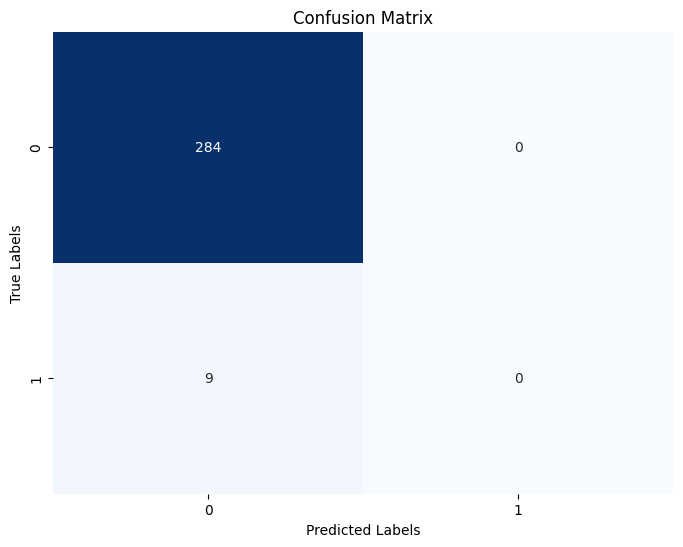

In [14]:
#visualizing model performance
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Split data into features and target
X = df[['Discounted Price', 'Actual Price', 'Discount Percentage', 'Rating Count']]
y = df['Rating']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
37/37 [==============================] - 14s 73ms/step - loss: 13.9430 - val_loss: 5.7430
Epoch 2/10
37/37 [==============================] - 1s 22ms/step - loss: 1.1969 - val_loss: 0.2069
Epoch 3/10
37/37 [==============================] - 1s 23ms/step - loss: 0.1447 - val_loss: 0.1079
Epoch 4/10
37/37 [==============================] - 1s 30ms/step - loss: 0.1079 - val_loss: 0.0945
Epoch 5/10
37/37 [==============================] - 1s 25ms/step - loss: 0.0956 - val_loss: 0.0920
Epoch 6/10
37/37 [==============================] - 1s 23ms/step - loss: 0.0891 - val_loss: 0.0856
Epoch 7/10
37/37 [==============================] - 1s 30ms/step - loss: 0.0879 - val_loss: 0.0888
Epoch 8/10
37/37 [==============================] - 1s 21ms/step - loss: 0.0863 - val_loss: 0.0829
Epoch 9/10
37/37 [==============================] - 1s 22ms/step - loss: 0.0844 - val_loss: 0.0825
Epoch 10/10
37/37 [==============================] - 1s 14ms/step - loss: 0.0847 - val_loss: 0.0823


In [16]:
# Evaluate the model
y_pred_lstm = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lstm)

10/10 [==============================] - 1s 4ms/step


In [17]:
# Train the model and record the training history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Access the history object
print(history.history.keys())


Epoch 1/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0838 - val_loss: 0.0816
Epoch 2/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0843 - val_loss: 0.0822
Epoch 3/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0837 - val_loss: 0.0830
Epoch 4/50
37/37 [==============================] - 0s 10ms/step - loss: 0.0831 - val_loss: 0.0826
Epoch 5/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0844 - val_loss: 0.0976
Epoch 6/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0872 - val_loss: 0.0807
Epoch 7/50
37/37 [==============================] - 0s 10ms/step - loss: 0.0838 - val_loss: 0.0811
Epoch 8/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0841 - val_loss: 0.0810
Epoch 9/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0833 - val_loss: 0.0815
Epoch 10/50
37/37 [==============================] - 0s 10ms/step - loss: 0.0827 - val_loss: 0.0803
Epoch 11/50
37/

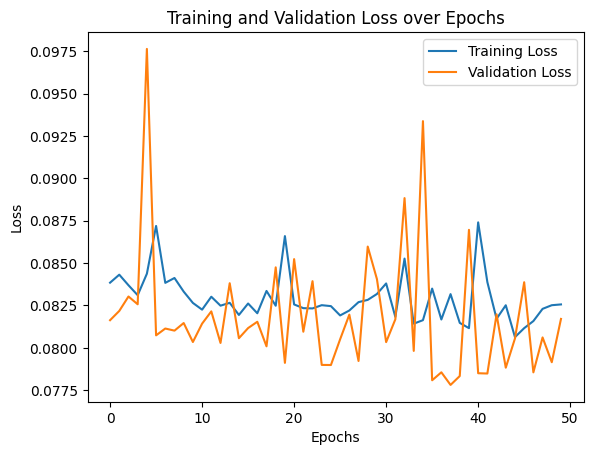

In [18]:

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()



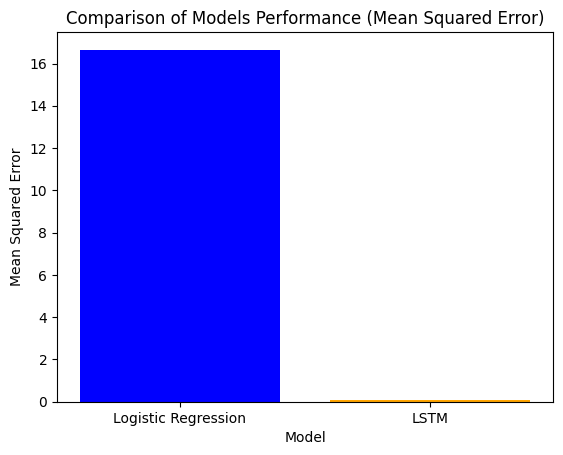

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Calculate mean squared error for Logistic Regression
mse_logreg = mean_squared_error(y_test, y_pred_logreg)

# Define metrics for comparison
mse_lstm = mean_squared_error(y_test, y_pred_lstm)

# Plotting
labels = ['Logistic Regression', 'LSTM']
metrics_values = [mse_logreg, mse_lstm]

plt.bar(labels, metrics_values, color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Models Performance (Mean Squared Error)')
plt.show()




10/10 [==============================] - 0s 3ms/step


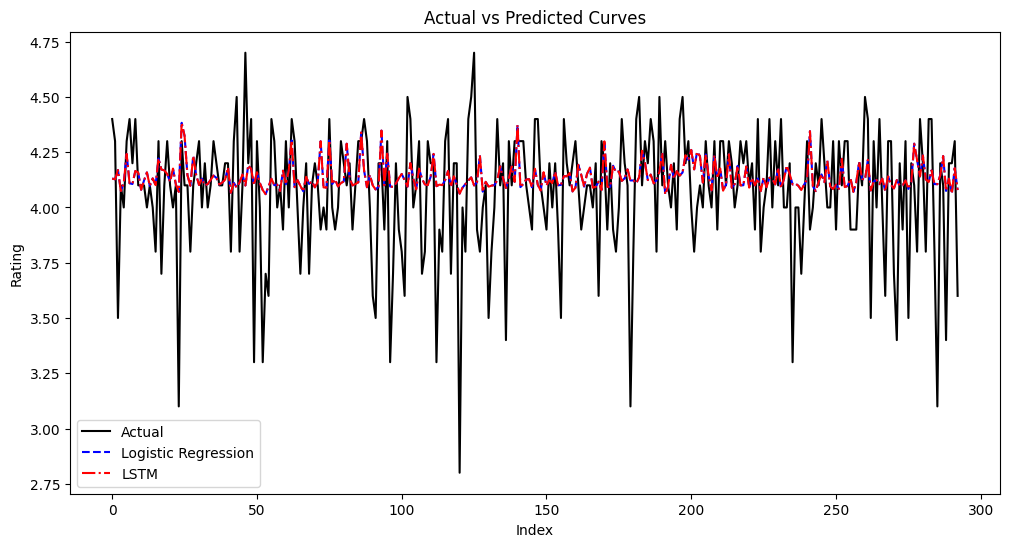

In [20]:
# Predictions for Logistic Regression
y_pred_logreg = model.predict(X_test)

# Reshape predictions for LSTM
y_pred_lstm = model.predict(X_test)
y_pred_lstm = y_pred_lstm.reshape(-1)

# Plot actual vs predicted curves
plt.figure(figsize=(12, 6))

# Plot actual curve
plt.plot(y_test.values, label='Actual', color='black')

# Plot predicted curve for Logistic Regression
plt.plot(y_pred_logreg, label='Logistic Regression', linestyle='--', color='blue')

# Plot predicted curve for LSTM
plt.plot(y_pred_lstm, label='LSTM', linestyle='-.', color='red')

plt.xlabel('Index')
plt.ylabel('Rating')
plt.title('Actual vs Predicted Curves')
plt.legend()
plt.show()
